In [1]:
!pip install -q contractions scikit-learn==1.7.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import re
import random
from pathlib import Path
import random
import contractions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk

from nltk.corpus import stopwords
nltk.download("stopwords")

from nltk.corpus import wordnet
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
label_map = {
    0: "Human Necessities",
    1: "Performing Operations;Transporting",
    2: "Chemistry;Metallurgy",
    3: "Textiles; Paper",
    4: "Fixed Constructions",
    5: "Mechanical Engineering;Lightning;Heating;Weapons;Blasting",
    6: "Physics",
    7: "Electricity",
    8: "General tagging of new or cross-sectional technology"
}

train_path = "/kaggle/input/cs419-dataset/CS419_dataset/train-00000-of-00001.parquet"
val_path   = "/kaggle/input/cs419-dataset/CS419_dataset/validation-00000-of-00001.parquet"
test_path  = "/kaggle/input/cs419-dataset/CS419_dataset/test-00000-of-00001.parquet"

train_df = pd.read_parquet(train_path)
val_df   = pd.read_parquet(val_path)
test_df  = pd.read_parquet(test_path)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

# Check columns - we expect at least `text` and `label`
print(train_df.columns.tolist())

Train: (25000, 2)
Val: (5000, 2)
Test: (5000, 2)
['text', 'label']


In [4]:
# Light preprocessing (keep sentences intact for tokenizer)
# important_neg = {"not", "no", "never", "cannot", "n't"}
# stop_words = set(stopwords.words("english")) - important_neg

stop_words = set(stopwords.words("english"))

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def light_preprocess(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)

    # # Expand contractions
    # text = contractions.fix(text)

    # lowercase + remove newline
    text = text.lower().strip()
    text = text.replace('\n', ' ')

    # remove URLs & mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)

    # keep only alphabet + number
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # stopword removal
    tokens = text.split()
    filtered_tokens = [t for t in tokens if t not in stop_words]

    # stemming
    filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]

    # lemmatize
    # filtered_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens]

    return " ".join(filtered_tokens)

train_df["clean_text"] = train_df["text"].astype(str).apply(light_preprocess)
val_df["clean_text"]   = val_df["text"].astype(str).apply(light_preprocess)
test_df["clean_text"]  = test_df["text"].astype(str).apply(light_preprocess)

assert "label" in train_df.columns, "train_df must contain a 'label' column"

unique_labels = sorted(train_df["label"].unique())
print("Unique train labels:", unique_labels)

Unique train labels: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [5]:
# 1. Chuẩn bị dữ liệu đầu vào
X_train = train_df["clean_text"]
y_train = train_df["label"]

X_val = val_df["clean_text"]
y_val = val_df["label"]

X_test = test_df["clean_text"]
y_test = test_df["label"]

In [6]:
# 2. Xây dựng Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        sublinear_tf=True,
        norm='l2'
    )),
    ('clf', LogisticRegression(
        max_iter=8000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=168
    ))
])

In [7]:
# 3. Thiết lập GridSearch
param_grid = {
    'tfidf__max_features': [100_000, 200_000, 300_000],
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.5, 1, 1.5, 2]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,            # Cross-validation 3-fold 
    scoring='f1_weighted', # Tối ưu hóa theo F1-score (tốt cho đa lớp)
    n_jobs=-1,       # Sử dụng tất cả các lõi CPU
    verbose=0,
    # error_score="raise"
)

In [8]:
# 4. Train
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,estimator,Pipeline(step..._state=168))])
,param_grid,"{'clf__C': [0.5, 1, ...], 'tfidf__max_df': [0.8, 0.9], 'tfidf__max_features': [100000, 200000, ...], 'tfidf__min_df': [5, 10], ...}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [9]:
# 5. Kết quả tốt nhất
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# 6. Đánh giá trên tập Validation và Test
best_model = grid_search.best_estimator_

joblib.dump(best_model, "patent_logreg_tfidf.pkl")
print("Model saved!")

print("\n--- Validation Report ---")
y_val_pred = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred, target_names=list(label_map.values())))

Best Params: {'clf__C': 2, 'tfidf__max_df': 0.9, 'tfidf__max_features': 100000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best CV Score: 0.6131041749770014
Model saved!

--- Validation Report ---
                                                           precision    recall  f1-score   support

                                        Human Necessities       0.74      0.69      0.71       703
                       Performing Operations;Transporting       0.58      0.56      0.57       705
                                     Chemistry;Metallurgy       0.61      0.81      0.69       421
                                          Textiles; Paper       0.57      0.62      0.60        40
                                      Fixed Constructions       0.49      0.71      0.58       146
Mechanical Engineering;Lightning;Heating;Weapons;Blasting       0.50      0.65      0.56       347
                                                  Physics       0.70      0.68      0.69      1092
   

In [10]:
print("\nTest Report")
y_test_pred = best_model.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=list(label_map.values())))


Test Report
                                                           precision    recall  f1-score   support

                                        Human Necessities       0.74      0.68      0.71       754
                       Performing Operations;Transporting       0.58      0.55      0.57       649
                                     Chemistry;Metallurgy       0.57      0.80      0.67       394
                                          Textiles; Paper       0.63      0.59      0.61        44
                                      Fixed Constructions       0.49      0.67      0.56       156
Mechanical Engineering;Lightning;Heating;Weapons;Blasting       0.49      0.63      0.55       358
                                                  Physics       0.71      0.69      0.70      1107
                                              Electricity       0.72      0.73      0.72      1035
     General tagging of new or cross-sectional technology       0.24      0.15      0.18       

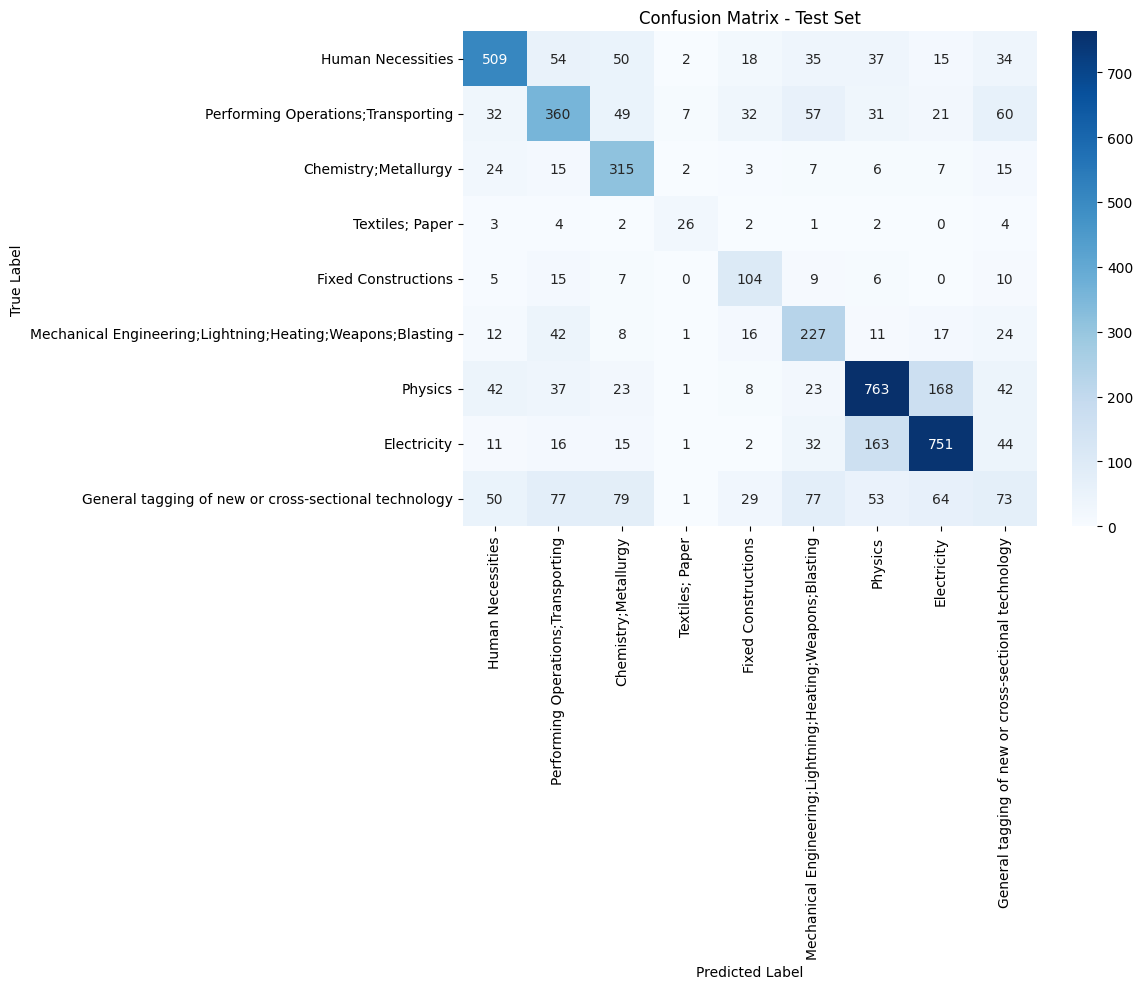

In [11]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_map.values(),
    yticklabels=label_map.values()
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

In [12]:
test_results = test_df.copy()
test_results["y_true"] = y_test.values
test_results["y_pred"] = y_test_pred
test_results["correct"] = test_results["y_true"] == test_results["y_pred"]

In [13]:
def sample_per_class(df, k=2, seed=168):
    return (
        df.groupby("y_true", group_keys=False)
          .apply(lambda x: x.sample(min(len(x), k), random_state=seed))
    )

print("\nCORRECT (per class)")
correct_samples = sample_per_class(
    test_results[test_results["correct"]], k=3
)

print("\nWRONG (per class)")
wrong_samples = sample_per_class(
    test_results[~test_results["correct"]], k=3
)

def print_samples(df, title):
    print(f"\n=== {title} ===")
    for _, row in df.iterrows():
        print("-" * 80)
        print("True:", label_map[row["y_true"]])
        print("Pred:", label_map[row["y_pred"]])
        print("Text:", row["text"][:500])

print_samples(correct_samples, "CORRECT SAMPLES")
print_samples(wrong_samples, "WRONG SAMPLES")


CORRECT (per class)

WRONG (per class)

=== CORRECT SAMPLES ===
--------------------------------------------------------------------------------
True: Human Necessities
Pred: Human Necessities
Text: referring now more specifically to the drawings , the numeral 10 generally designates a first form of golf cart constructed in accordance with the present invention . the golf cart 10 includes an upstanding frame referred to in general by the reference numeral 12 and the frame 12 includes upstanding opposite side members 14 and 16 interconnected at their lower ends by means of a horizontal transverse member 18 . the upper end portions 20 and 22 of the opposite side members 14 and 16 are upwardly
--------------------------------------------------------------------------------
True: Human Necessities
Pred: Human Necessities
Text: the following examples are offered by way of illustration and are not intended to limit the invention in any manner . in the examples , all temperatures are in degr

/tmp/ipykernel_13/662025551.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), k), random_state=seed))
/tmp/ipykernel_13/662025551.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), k), random_state=seed))


In [14]:
SAMPLES_PER_CLASS = 2

# Tạo dataframe tạm để dễ group
viz_df = train_df[["clean_text", "label"]].copy()

viz_df = (
    viz_df
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(
        n=min(len(x), SAMPLES_PER_CLASS),
        random_state=168
    ))
    .reset_index(drop=True)
)

X_viz_text = viz_df["clean_text"]
y_viz = viz_df["label"].values

/tmp/ipykernel_13/674468383.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


In [15]:
# Lấy TF-IDF đã train
tfidf = best_model.named_steps["tfidf"]
X_viz_tfidf = tfidf.transform(X_viz_text)

# Giảm chiều
svd = TruncatedSVD(n_components=2, random_state=168)
scaler = StandardScaler()

X_viz_2d = make_pipeline(svd, scaler).fit_transform(X_viz_tfidf)

In [16]:
best_C = best_model.named_steps["clf"].C

logreg_2d = LogisticRegression(
    class_weight='balanced',
    max_iter=8000,
    n_jobs = -1,
    random_state=168
)

logreg_2d.fit(X_viz_2d, y_viz)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,168
,solver,'lbfgs'
,max_iter,8000
,multi_class,'deprecated'


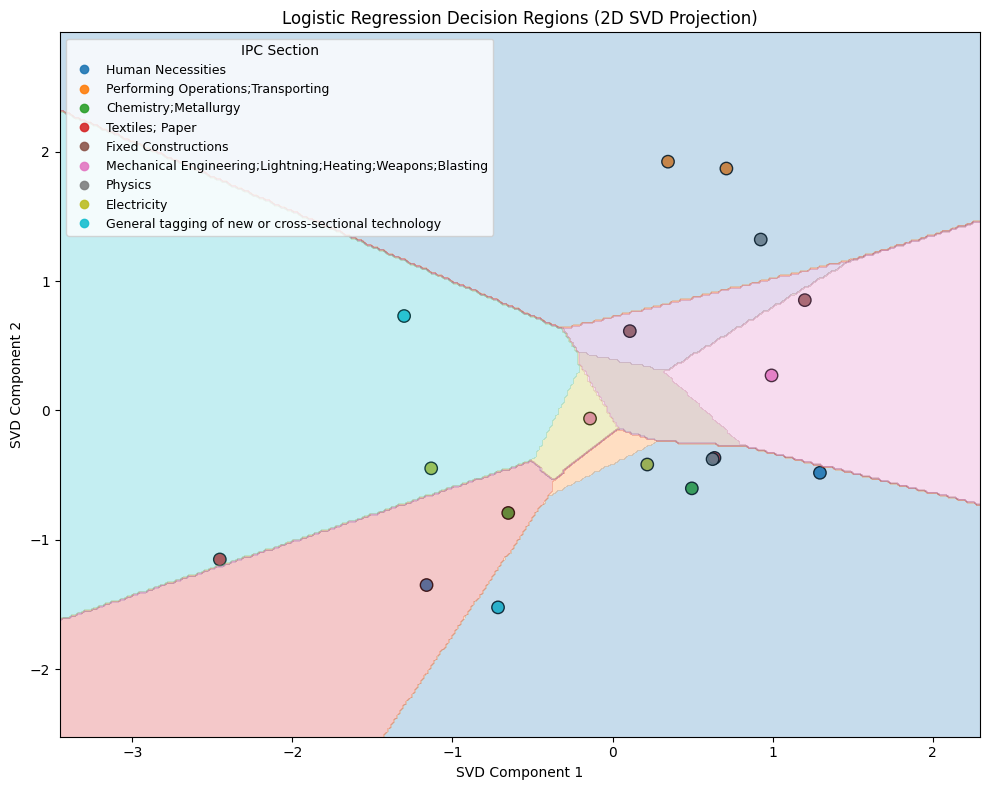

In [17]:
plt.figure(figsize=(10, 8))

# Scatter points
scatter = plt.scatter(
    X_viz_2d[:, 0],
    X_viz_2d[:, 1],
    c=y_viz,
    cmap="tab10",
    s=80,
    edgecolors="k",
    alpha=0.9
)

# Grid
x_min, x_max = X_viz_2d[:, 0].min() - 1, X_viz_2d[:, 0].max() + 1
y_min, y_max = X_viz_2d[:, 1].min() - 1, X_viz_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = logreg_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Decision regions
plt.contourf(
    xx, yy, Z,
    alpha=0.25,
    cmap="tab10"
)

# Legend
handles, _ = scatter.legend_elements()
labels = [label_map[i] for i in sorted(np.unique(y_viz))]
plt.legend(handles, labels, title="IPC Section", fontsize=9)

plt.title("Logistic Regression Decision Regions (2D SVD Projection)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.tight_layout()
plt.show()